# Wavefield Separation FWI sensitivity kernel
We compare sensitivity kernels in a half-space model with wavefield separation imaging conditions. Wavefield separation in the imaging condition can both enhance long wavelength FWI gradients (for FWI), and remove long wavelength backscattered energy (for RTM) and is implemented as a wavenumber filter in Kz following Faqi et. al. (2011).

### Workflow for the standard FWI imaging condition
The standard imaging condition will have short wavelengths in the FWI image, and also long wavelengths in the RTM image.
1. Generate forward modeled data in true model
1. Generate forward modeled data in perturbed model
1. Backproject the residual  
1. At every time step
    * Zero lag correlation of forward source wavefield `S` with backward receiver wavefield `R` at every point in the model: <br>
    `Image += S * R`

### Workflow for the wavefield separation FWI imaging condition
This will enhance long wavelengths in the image.
1. Generate forward modeled data in true model
1. Generate forward modeled data in perturbed model
1. Backproject the residual  
1. At every time step
    * Spatial Fourier transform the source and receiver wavefields in depth (2 FFTs) --> `ZS`, `ZR`
    * Apply diagonal operators to zero positive and negative frequencies to both `ZS` and `ZR`, generating `ZSup`, `ZSdn`, `ZRup`, and `ZRdn`
    * Inverse spatial Fourier transform in depth (4 FFTs) to generate `Sup`, `Sdn`, `Rup`, `Rdn`
    * Zero lag correlation at every point in the model: <br>
    `Image += Sup * Rup + Sdn * Rdn`

### Workflow for the wavefield separation RTM imaging condition
This will remove long wavelength backscattered energy from the image.
1. Generate forward modeled data in true model
1. Generate forward modeled data in water velocity model
1. Subtracting water velocity data from true data to remove direct arrival
1. Backproject the direct arrival removed true data
1. At every time step
    * Spatial Fourier transform the source and receiver wavefields in depth (2 FFTs) --> `ZS`, `ZR`
    * Apply diagonal operators to zero positive and negative frequencies to both `ZS` and `ZR`, generating `ZSup`, `ZSdn`, `ZRup`, and `ZRdn`
    * Inverse spatial Fourier transform in depth (4 FFTs) to generate `Sup`, `Sdn`, `Rup`, `Rdn`
    * Zero lag correlation at every point in the model: <br>
    `Image += Sup * Rdn + Sdn * Rup`

### Workflow for the mixed RTM imaging condition
This is a linear combination of the RTM and standard FWI imaging condition.

### Note on conjugate symmetry
We can simplify further and only require two inverse Fourier transforms for each time step by following Faqi et. al. (2011). Please see the discussion between equation 9 and 10, this is what is implmented in `JetPackWaveFD`.

### Reference
* *An effective imaging condition for reverse-time migration using wavefield decomposition* 2011<br>
Faqi Liu, Guanquan Zhang, Scott A. Morton, and Jacques P. Leveille
https://library.seg.org/doi/full/10.1190/1.3533914

In [3]:
using PyPlot, Jets, WaveFD, JetPackWaveFD, Random, LinearAlgebra

## Make three models
* true halfspace model with velocities 1500 m/s over 2000 m/s
* perturbed halfspace model with velocities 1505 m/s over 2000 m/s
* water velocity model at 1500 m/s

We make the perturbed model slightly faster in the upper half-space, which indicates that the gradients for FWI should be all positive.

Even though this is a 2D example, the model passed to the nonlinear operator below is 3D, with size [nz,nx,1] for the velocity only case. In the case of variable density acoustics, the model would be of size [nz,nx,2]. 

In [4]:
nz,nx = 150,600
dz,dx = 20.0,20.0
z2 = 101

mtrue = 1500 .* ones(Float32,nz,nx,1);
mtrue[z2:end,:,1] .= 2000;

mpert = 1510 .* ones(Float32,nz,nx,1);
mpert[z2:end,:,1] .= 2000;

mwater = 1500 .* ones(Float32,nz,nx,1);

/home/cvx/.conda/envs/conda_jl/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/cvx/.conda/envs/conda_jl/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


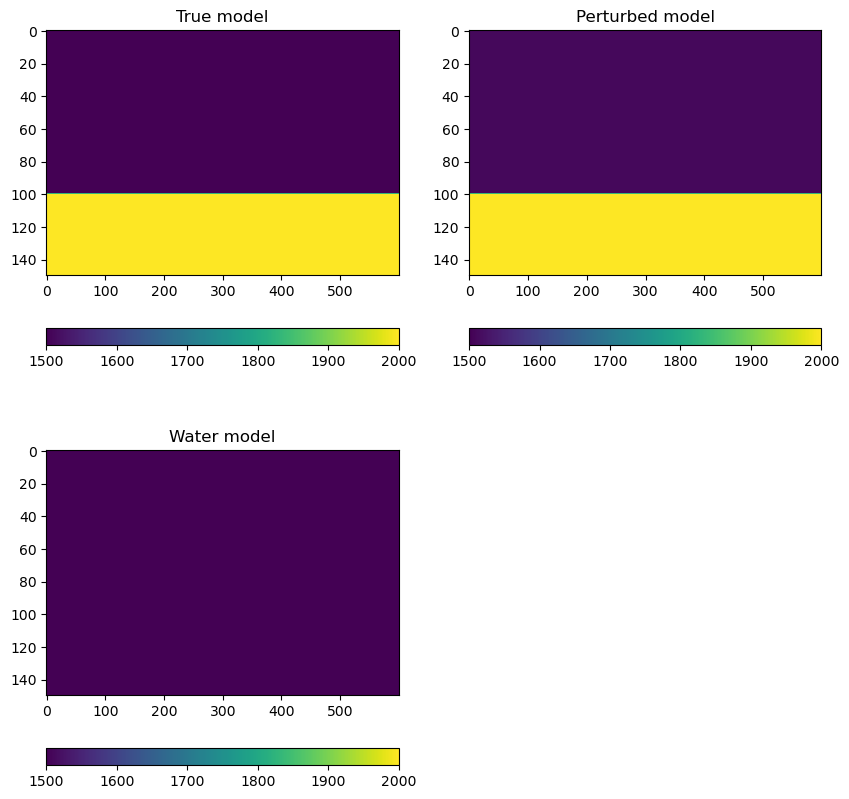

In [5]:
figure(figsize=(10,10))
vmin,vmax = extrema(mtrue)
subplot(2,2,1);imshow(mtrue[:,:,1],aspect="auto"); title("True model"); clim(vmin,vmax);
colorbar(orientation="horizontal")
subplot(2,2,2);imshow(mpert[:,:,1],aspect="auto"); title("Perturbed model"); clim(vmin,vmax)
colorbar(orientation="horizontal");
subplot(2,2,3);imshow(mwater[:,:,1],aspect="auto"); title("Water model"); clim(vmin,vmax)
colorbar(orientation="horizontal");

## Note on scratch space for temporary files
When dealing with serialized nonlinear wavefields as in this example, we need to specify the location where scratch files will be written.

You may need to change this to point to a temporary directory available on your system.

In [6]:
scratch = "/mnt/scratch"
@assert isdir(scratch)

## Make four operators
* Standard imaging condition 
* FWI imaging condition 
* RTM imaging condition
* MIX imaging condition

In [35]:
ntrec = 2001
dtrec = 0.004
dtmod = 0.002

sz = dz * 1;
sx = dx * div(nx,2);
rz = dz .* ones(Float32, nx);
rx = dx .* Float32[0:(nx-1);];

compscale = 1e-1

Fstd = JopNlProp2DAcoIsoDenQ_DEO2_FDTD(; b = ones(Float32,nz,nx),
    comptype = UInt32, compscale = compscale,
    nthreads = Sys.CPU_THREADS, isinterior = true, nsponge = 80,
    ntrec = ntrec, dtrec = dtrec, dtmod = dtmod, dz = dz, dx = dx,
    wavelet = WaveletCausalRicker(f=5), sx = sx, sz = sz, rx = rx, rz = rz,
    srcfieldfile = joinpath(scratch, "field-$(randstring()).bin"),
    reportinterval=0, imgcondition = "standard");

Ffwi = JopNlProp2DAcoIsoDenQ_DEO2_FDTD(; b = ones(Float32,nz,nx),
    comptype = UInt32, compscale = compscale,
    nthreads = Sys.CPU_THREADS, isinterior = true, nsponge = 80,
    ntrec = ntrec, dtrec = dtrec, dtmod = dtmod, dz = dz, dx = dx,
    wavelet = WaveletCausalRicker(f=5), sx = sx, sz = sz, rx = rx, rz = rz,
    srcfieldfile = joinpath(scratch, "field-$(randstring()).bin"),
    reportinterval=0, imgcondition = "FWI");

Frtm = JopNlProp2DAcoIsoDenQ_DEO2_FDTD(; b = ones(Float32,nz,nx),
    comptype = UInt32, compscale = compscale,
    nthreads = Sys.CPU_THREADS, isinterior = true, nsponge = 80,
    ntrec = ntrec, dtrec = dtrec, dtmod = dtmod, dz = dz, dx = dx,
    wavelet = WaveletCausalRicker(f=5), sx = sx, sz = sz, rx = rx, rz = rz,
    srcfieldfile = joinpath(scratch, "field-$(randstring()).bin"),
    reportinterval=0, imgcondition = "RTM");

weight = 0
Fmix = JopNlProp2DAcoIsoDenQ_DEO2_FDTD(; b = ones(Float32,nz,nx),
    comptype = UInt32, compscale = compscale,
    nthreads = Sys.CPU_THREADS, isinterior = true, nsponge = 80,
    ntrec = ntrec, dtrec = dtrec, dtmod = dtmod, dz = dz, dx = dx,
    wavelet = WaveletCausalRicker(f=5), sx = sx, sz = sz, rx = rx, rz = rz,
    srcfieldfile = joinpath(scratch, "field-$(randstring()).bin"),
    reportinterval=0, imgcondition = "MIX", RTM_weight=weight);

## Forward modeling
Generate data to be backprojected:
* FWI: backproject (d_pert - d_true)
* RTM: backproject (d_true - d_water)

In [30]:
dtrue = Fstd * mtrue;
dpert = Fstd * mpert;
dwater = Fstd * mwater;

rfwi = dpert .- dtrue
rrtm = dtrue .- dwater

@show extrema(dtrue)
@show extrema(dpert)
@show extrema(dwater)
@show extrema(rfwi)
@show extrema(rrtm)
nothing

extrema(dtrue) = (-0.21976617f0, 0.42180586f0)
extrema(dpert) = (-0.22014059f0, 0.4226329f0)
extrema(dwater) = (-0.21976617f0, 0.42180586f0)
extrema(rfwi) = (-0.0063335625f0, 0.007412592f0)
extrema(rrtm) = (-0.003895504f0, 0.008113886f0)


## Plot the generated data

scale = 644.7990928846247


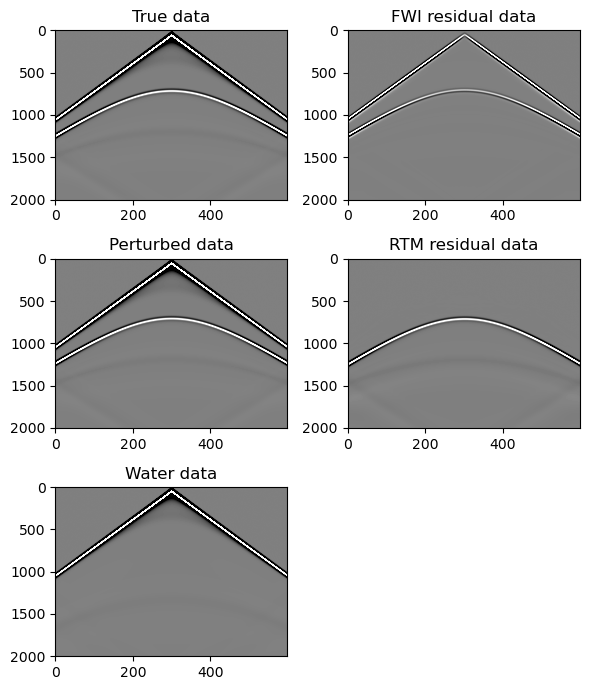

In [31]:
scale = 2.5 / sqrt(norm(dtrue)^2 / length(dtrue))
@show scale

figure(figsize=(6,7)); clf()
subplot(3,2,1); imshow(scale .* dtrue,cmap="gray",aspect="auto",clim=[-1,+1]); 
title("True data")
subplot(3,2,2); imshow(scale .* rfwi,cmap="gray",aspect="auto",clim=[-1,+1]); 
title("FWI residual data")
subplot(3,2,3); imshow(scale .* dpert,cmap="gray",aspect="auto",clim=[-1,+1]); 
title("Perturbed data")
subplot(3,2,4); imshow(scale .* rrtm,cmap="gray",aspect="auto",clim=[-1,+1]); 
title("RTM residual data")
subplot(3,2,5); imshow(scale .* dwater,cmap="gray",aspect="auto",clim=[-1,+1]); 
title("Water data")
tight_layout()
nothing

## Apply the three imaging conditions
Note we run the three forward modeling operators on the perturbed velocity in order to accurately time the application of the Jacobian.

In [32]:
Jstd = jacobian!(Fstd, mpert)
Jfwi = jacobian!(Ffwi, mpert)
Jrtm = jacobian!(Frtm, mpert)
Jmix = jacobian!(Fmix, mpert)

dfwi1 = Fstd * mpert;
dfwi2 = Ffwi * mpert;
drtm2 = Frtm * mpert;
dmix2 = Fmix * mpert;

tfwi1 = @elapsed fwi1 = Jstd' * rfwi;
tfwi2 = @elapsed fwi2 = Jfwi' * rfwi;
trtm1 = @elapsed rtm1 = Jstd' * rrtm;
trtm2 = @elapsed rtm2 = Jrtm' * rrtm;
tmix2 = @elapsed mix2 = Jmix' * rfwi;

@show extrema(fwi1)
@show extrema(fwi2)
@show extrema(rtm1)
@show extrema(rtm2)
@show extrema(mix2)

@info "FWI timing std=$(tfwi1) fwi=$(tfwi2) ratio=$(tfwi2/tfwi1)"
@info "RTM timing std=$(trtm1) fwi=$(trtm2) ratio=$(trtm2/trtm1)"
@info "FWI timing std=$(tfwi1) mix=$(tmix1) ratio=$(tfwi2/tfwi1)"
@info "FWI timing std=$(tfwi1) mix=$(tmix2) ratio=$(tmix2/tfwi1)"
nothing

extrema(fwi1) = (-1.5243714f-5, 8.3509425f-5)
extrema(fwi2) = (-3.0650062f-7, 2.2797776f-5)
extrema(rtm1) = (-1.7127702f-5, 1.9623774f-6)
extrema(rtm2) = (-3.864562f-6, 7.197374f-7)
extrema(mix2) = (-7.2765433f-6, 6.171244f-5)


[ Info: FWI timing std=0.728048769 fwi=1.198631943 ratio=1.646362158741594
[ Info: RTM timing std=0.767547546 fwi=1.216124426 ratio=1.5844287853406804
[ Info: FWI timing std=0.728048769 mix=0.701192388 ratio=1.646362158741594
[ Info: FWI timing std=0.728048769 mix=1.262668155 ratio=1.7343180962098432


## Plot the results
* Because in the perturbed model the upper half-space is faster, we expect the gradient to be positive (red). 
* Note how the FWI wavefield separation enhances long wavelengths
* Note how the RTM wavefield separation removes long wavelength backscattered energy

(scale_fwi1, scale_fwi2) = (363457.3161253513, 1.0314897765865554e6)
(scale_rtm1, scale_rtm2) = (283697.16525823716, 999061.3763399189)


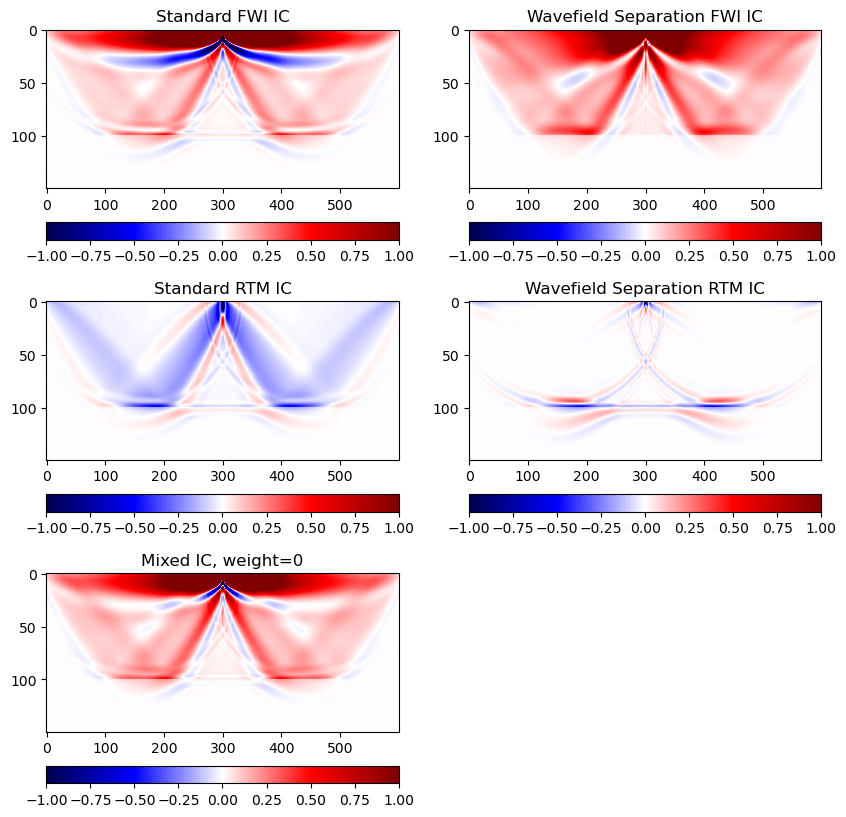

In [36]:
figure(figsize=(10,10))
scale_fwi1 = 0.5 / maximum(abs, fwi1[z2-10:z2+10,:,1])
scale_fwi2 = 0.5 / maximum(abs, fwi2[z2-10:z2+10,:,1])
scale_rtm1 = 0.5 / maximum(abs, rtm1[z2-10:z2+10,:,1])
scale_rtm2 = 0.5 / maximum(abs, rtm2[z2-10:z2+10,:,1])
scale_mix1 = 0.5 / maximum(abs, mix1[z2-10:z2+10,:,1])
scale_mix2 = 0.5 / maximum(abs, mix2[z2-10:z2+10,:,1])
@show scale_fwi1,scale_fwi2
@show scale_rtm1,scale_rtm2
subplot(3,2,1); imshow(fwi1[:,:,1].*scale_fwi1,aspect="auto",cmap="seismic",clim=[-1,1]);
title("Standard FWI IC");colorbar(orientation="horizontal")
subplot(3,2,2); imshow(fwi2[:,:,1].*scale_fwi2,aspect="auto",cmap="seismic",clim=[-1,1]);
title("Wavefield Separation FWI IC");colorbar(orientation="horizontal")
subplot(3,2,3); imshow(rtm1[:,:,1].*scale_rtm1,aspect="auto",cmap="seismic",clim=[-1,1]);
title("Standard RTM IC");colorbar(orientation="horizontal")
subplot(3,2,4); imshow(rtm2[:,:,1].*scale_rtm2,aspect="auto",cmap="seismic",clim=[-1,1]);
title("Wavefield Separation RTM IC");colorbar(orientation="horizontal")

subplot(3,2,5); imshow(mix2[:,:,1].*scale_mix2,aspect="auto",cmap="seismic",clim=[-1,1]);
title("Mixed IC, weight=$weight");colorbar(orientation="horizontal")


nothing


# Mixed
Let's run the mixed imaging condition for various weights

In [52]:
mix = Dict()
for (i,weight) in enumerate((0.0, 0.25, 0.5, 0.75, 1.0))
    @show i,weight
    Fmix = JopNlProp2DAcoIsoDenQ_DEO2_FDTD(; b = ones(Float32,nz,nx),
        comptype = UInt32, compscale = compscale,
        nthreads = Sys.CPU_THREADS, isinterior = true, nsponge = 80,
        ntrec = ntrec, dtrec = dtrec, dtmod = dtmod, dz = dz, dx = dx,
        wavelet = WaveletCausalRicker(f=5), sx = sx, sz = sz, rx = rx, rz = rz,
        srcfieldfile = joinpath(scratch, "field-$(randstring()).bin"),
        reportinterval=0, imgcondition = "MIX", RTM_weight=weight);

    Jmix = jacobian(Fmix, mpert)
    mix[i] = Jmix' * rfwi;
end

(i, weight) = (1, 0.0)
(i, weight) = (2, 0.25)
(i, weight) = (3, 0.5)
(i, weight) = (4, 0.75)
(i, weight) = (5, 1.0)


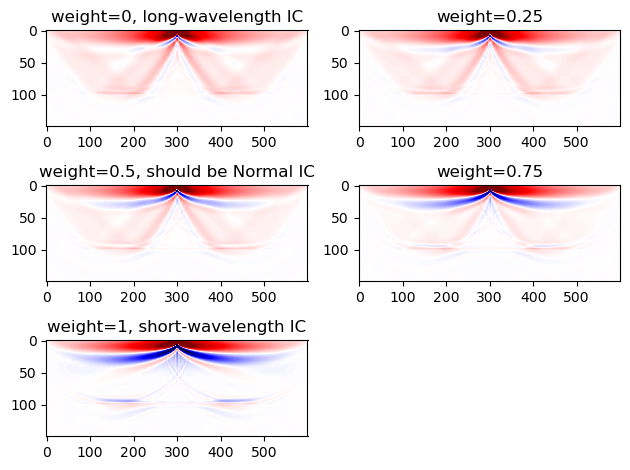

In [55]:
subplot(321);imshow(mix[1],aspect="auto",clim=[-1,1]*maximum(abs,mix[1])*.1,cmap="seismic");title("weight=0, long-wavelength IC")
subplot(322);imshow(mix[2],aspect="auto",clim=[-1,1]*maximum(abs,mix[2])*.1,cmap="seismic");title("weight=0.25")
subplot(323);imshow(mix[3],aspect="auto",clim=[-1,1]*maximum(abs,mix[3])*.1,cmap="seismic");title("weight=0.5, should be Normal IC")
subplot(324);imshow(mix[4],aspect="auto",clim=[-1,1]*maximum(abs,mix[4])*.1,cmap="seismic");title("weight=0.75")
subplot(325);imshow(mix[5],aspect="auto",clim=[-1,1]*maximum(abs,mix[5])*.1,cmap="seismic");title("weight=1, short-wavelength IC")
tight_layout()